<a href="https://colab.research.google.com/github/lalexandreti/chute_certo/blob/main/appdoschutes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aplicação Desenvolvida pelo Mestrando Luiz Alexandre Rodrigues Silva
# ---------------- Simulação de Monte Carlo (Beta) — Eficiência de Conversão de Chutes ao gol de um time da Série A ----------------
# ----------------  Time escolhido para estudo: Palmeiras ----------------
# ----------------  Temporada de 2023 completa (Serie A e Libertadores) ----------------
# ----------------  Temporada de 2024 completa (Serie A e Libertadores) ----------------
# ----------------  Temporada de 2025 parcial (Serie A, Mundial de Clubes e Libertadores) ----------------


,temporada,total_de_chutes,chutes_no_gol,gols,defendidos,chutes_para_fora,bloqueados,na_trave
0,2023,800,276,84,192,400,124,12
1,2024,778,253,75,178,283,242,13
2,2025,473,150,53,97,208,115,6


Gols no Período = 212  | Chutes a Gol no período = 679  | Probabilidade de um Chute ser Gol nesse período = 0.3122238586156112
Então é de = 31.22238586156112  % a chance de um chute ser gol
#----------------  prior uniforme e Jeffreys ---------------- 


,prior,stat,valor
0,uniforme,mean,0.312684
1,uniforme,IC90,[0.284; 0.342]
2,Jeffreys,mean,0.312416
3,Jeffreys,IC90,[0.284; 0.342]


# ----------------  POSTERIOR DE BETA PARAMETROS ---------------- 


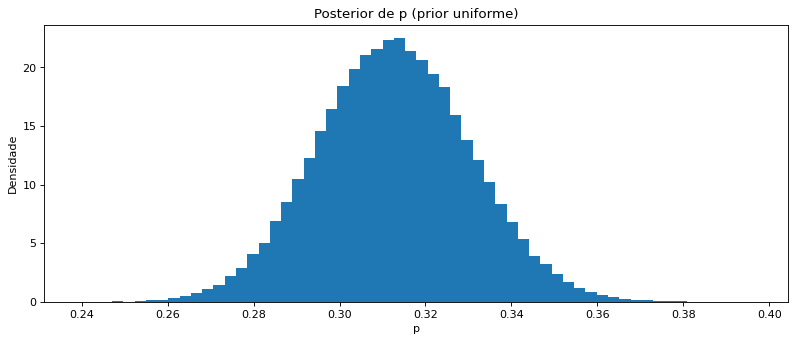

#----------------  POSTERIOR DE BETA BINOMIAL PREDITIVA ---------------- 


,S* (chutes a gol),G_mean,P(G>=1),P(G>=2),P(G>=3)
0,4,1.250117,0.776092,0.370200,0.094142
1,6,1.868708,0.891208,0.602442,0.279367
2,8,2.502658,0.950100,0.768283,0.482625


#----------------  DISTRIBUIÇÃO PREDITIVA DE GOLS ---------------- 


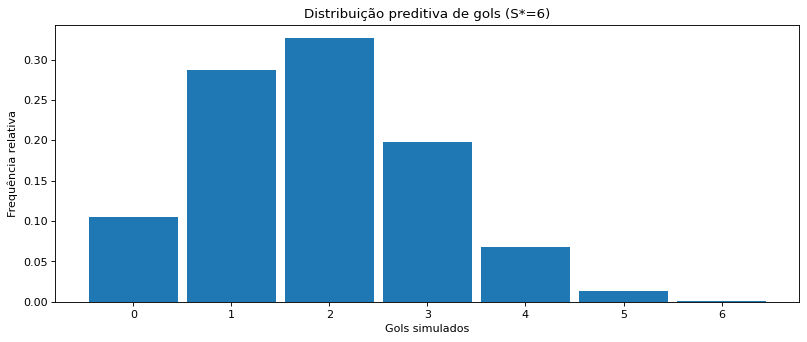

#----------------  NECESSIDADE DE CHUTES AO GOL PARA SE FAZER K GOL'S (DEFAULT 5 GOLS) ---------------- 
SOT para 5 gols: {'Média aritmética': 16.06218, 'mediana': 15.0, 'limiar dos 10% menores': 9.0, 'limiar dos 10% maiores para baixo': 24.0}
#----------------  POSSIBILIDADE DE GOL EM QUAL MINUTO DE ACORDO COM AS FINALIZAÇÕES NO ALVO---------------- 
Min SOT p/ P(G>=5)≥80%: 21  | ≥90%: 24
#----------------  TEMPO PARA SAIR UM GOL DE ACORDO COM A EXPONENCIAL E WEIBULL (EM MINUTOS)---------------- 
Tempo até gol (Exp, min): {'Média aritmética': 16.09165902715355, 'mediana': 11.09842878554353, 'limiar dos 10% menores': 1.7116670129396039, 'limiar dos 10% maiores para baixo': 36.96993387743488}
Tempo até gol (Weibull, min): {'Média aritmética': 16.172468414566044, 'mediana': 14.066642450516365, 'limiar dos 10% menores': 3.9249854323823414, 'limiar dos 10% maiores para baixo': 31.19448409159554}


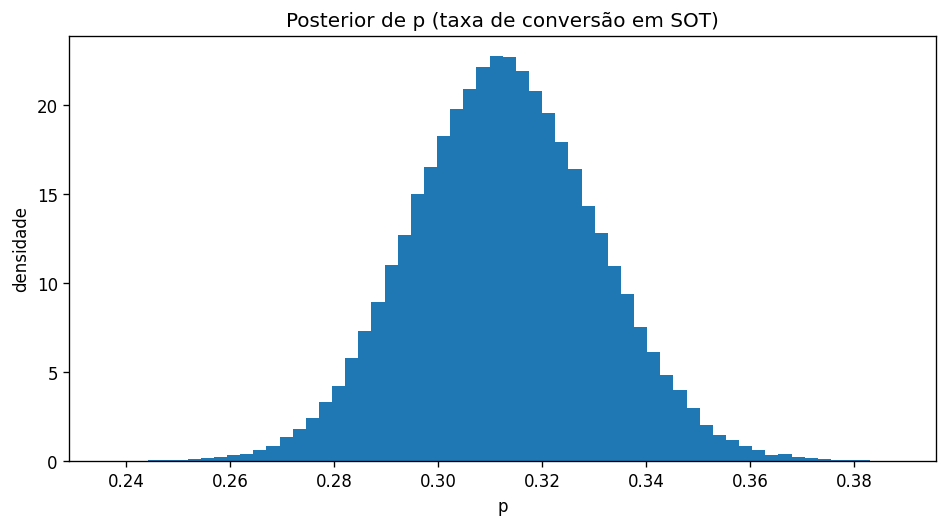

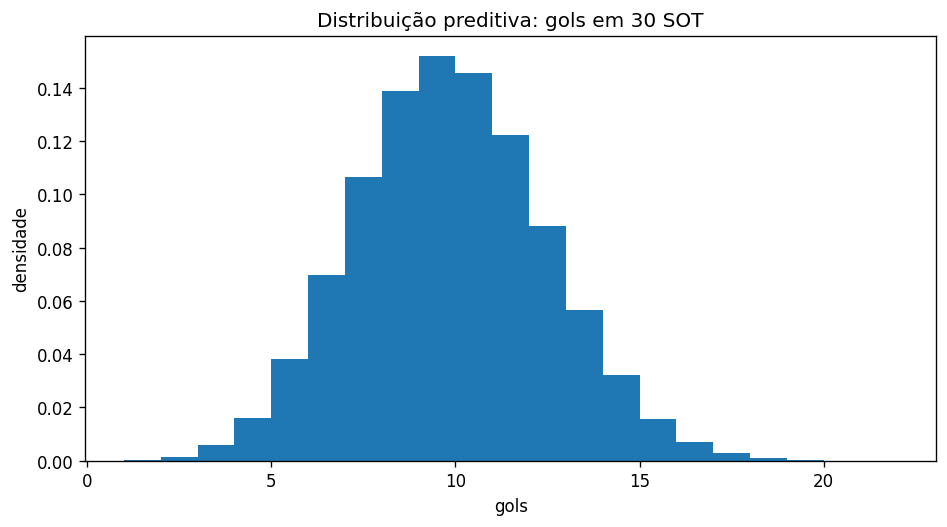

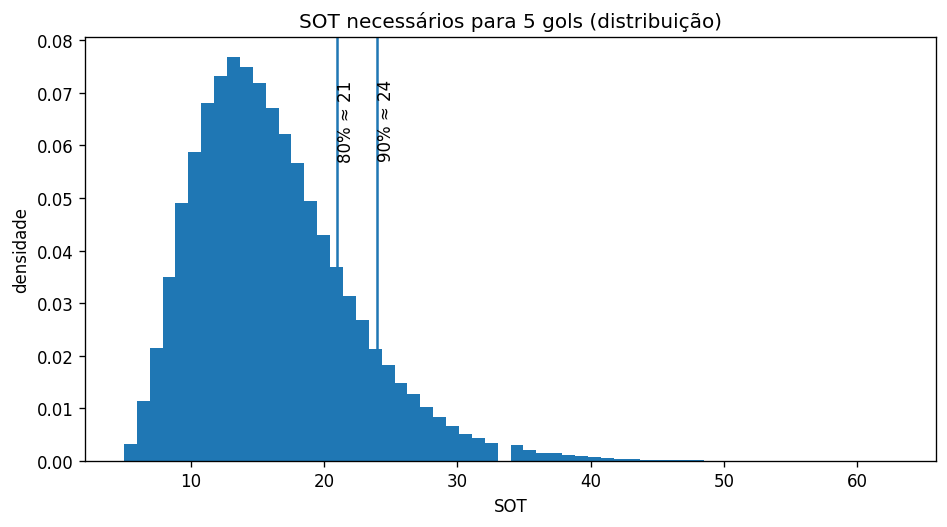

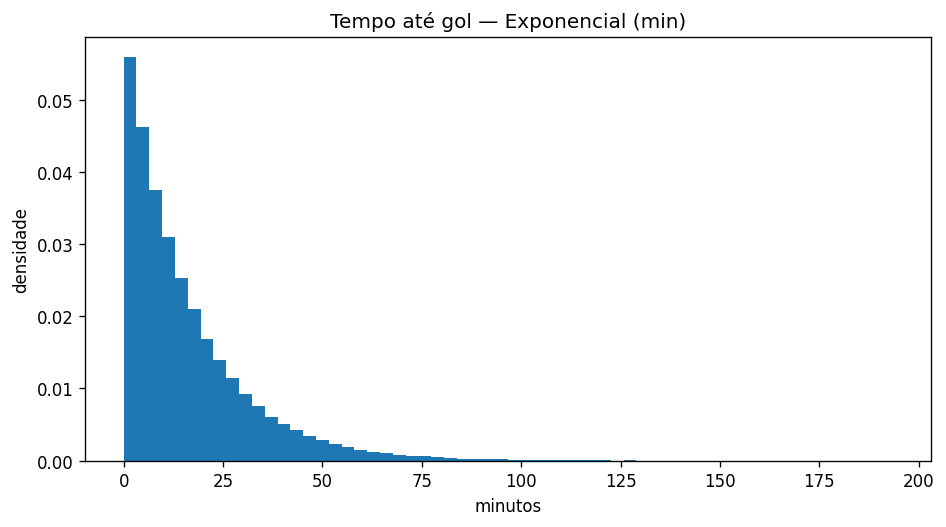

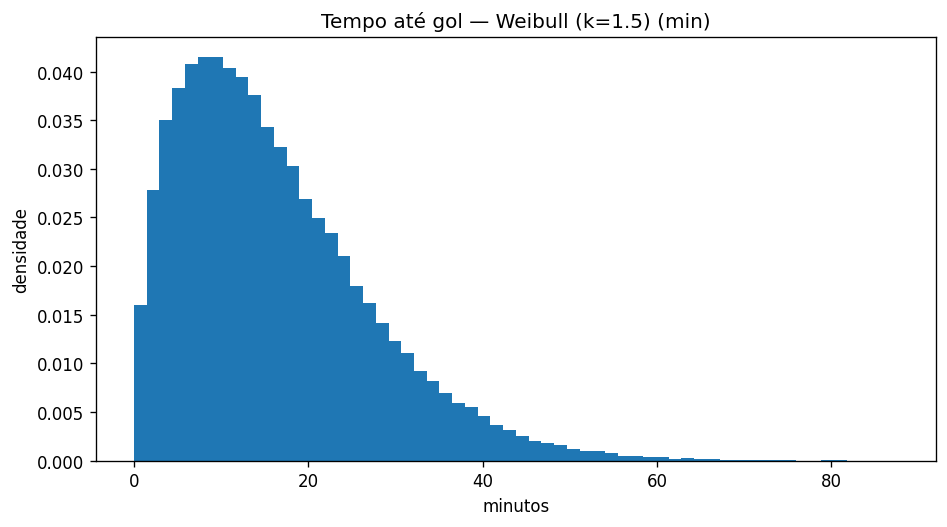

In [7]:
print("Aplicação Desenvolvida pelo Mestrando Luiz Alexandre Rodrigues Silva")
print("# ---------------- Simulação de Monte Carlo (Beta) — Eficiência de Conversão de Chutes ao gol de um time da Série A ----------------")
print("# ----------------  Time escolhido para estudo: Palmeiras ----------------")
print("# ----------------  Temporada de 2023 completa (Serie A e Libertadores) ----------------")
print("# ----------------  Temporada de 2024 completa (Serie A e Libertadores) ----------------")
print("# ----------------  Temporada de 2025 parcial (Serie A, Mundial de Clubes e Libertadores) ----------------")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import io
from typing import Tuple, Optional
from scipy.special import gamma


plt.rcParams['figure.figsize'] = (12, 4.5)
plt.rcParams['figure.dpi'] = 80

# -------- DEMONSTRANDO O CAMINHO DO ARQUIVO .CSV

csv_path = "estatisticas_fbref.csv"            # Jupyter local (esse arquivo precisa estar nesta mesma pasta do notebook)
# csv_path = r"F:\Python-Projetos\AEDI\estatisticas_fbref.csv"  # caminho absoluto no Windows

# -------- realizando verificação da existência do arquivo
import os
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Arquivo não encontrado em: {csv_path}")

# -------- Carregando os dados do arquivo .CSV, se for importar do fbref, precisa fazer scrapper no site, pois não tem todas as informações em um único local.
# -------- por exemplo, as informações estão em https://fbref.com/en/squads/abdce579/2023/matchlogs/all_comps/shooting/Palmeiras-Match-Logs-All-Competitions referentes
# -------- ao de 2023, porém os dados de bola na trave e finalizações bloqueadas, precisam ser percorridos em cada Match Report da página
# -------- como exemplo é preciso varrer os jogos para apurar os dados, como neste link https://fbref.com/en/matches/2f04093d/Palmeiras-Flamengo-July-8-2023-Serie-A
# -------- só a partir desta extração e tratamento dos dados que é possível, ter as informações para construção da simulação de Monte Carlo
df = pd.read_csv(csv_path)
display(df.head())

# -------- Definindo variáveis para correlacionar com as colunas do arquivo, no caso o total de gols e total de chutes, com o nª de gols e nº de finalizações
Total_de_gols = int(df["gols"].sum())
Total_de_chutes = int(df["chutes_no_gol"].sum())


# -------- definindo a primeira fórmula para calcular uma "EStimativa pontual" de probabilidade de sucesso de gol nas finalizações realizadas,
# -------- a partir de números absolutos de maneira "bem sumaria" e imprimindo o resulado apurado na tela.
print("Gols no Período =", Total_de_gols, " | Chutes a Gol no período =", Total_de_chutes,
      " | Probabilidade de um Chute ser Gol nesse período =", Total_de_gols / Total_de_chutes if Total_de_chutes else float("nan"))

print("Então é de =", ((Total_de_gols / Total_de_chutes) if Total_de_chutes else float("nan"))* 100, " % a chance de um chute ser gol")


# -------- incluindo outras Funções auxiliares

# -------- POSTERIOR DE BETA PARAMETROS

def posterior_beta_params(gols, chutes_no_gol, prior_alpha=1.0, prior_beta=1.0):
    alpha = prior_alpha + gols
    beta  = prior_beta + (chutes_no_gol - gols)
    return float(alpha), float(beta)


#--------- POSTERIOR DE BETA CARREGADA

def beta_posterior_samples(alpha, beta, n=100_000, seed=42):
    rng = np.random.default_rng(seed)
    return rng.beta(alpha, beta, size=n)


#--------- POSTERIOR DE BETA PBINOMIAL PREDITIVA

def beta_binomial_predictive(p_samples, S_star, seed=123):
    rng = np.random.default_rng(seed)
    return rng.binomial(S_star, p_samples)

def summarize(arr):
    return pd.Series({
        "mean":   float(np.mean(arr)),
        "median": float(np.median(arr)),
        "p10":    float(np.percentile(arr, 10)),
        "p90":    float(np.percentile(arr, 90)),
    })



print("#----------------  prior uniforme e Jeffreys ---------------- ")

alpha_u, beta_u = posterior_beta_params(Total_de_gols, Total_de_chutes, 1.0, 1.0)   # prior uniforme
alpha_j, beta_j = posterior_beta_params(Total_de_gols, Total_de_chutes, 0.5, 0.5)   # prior de Jeffreys

p_u = beta_posterior_samples(alpha_u, beta_u, n=120_000, seed=1)
p_j = beta_posterior_samples(alpha_j, beta_j, n=120_000, seed=2)

res_post = pd.DataFrame({
    "prior": ["uniforme", "uniforme", "Jeffreys", "Jeffreys"],
    "stat":  ["mean",      "IC90",     "mean",      "IC90"],
    "valor": [
        p_u.mean(), f"[{np.percentile(p_u,5):.3f}; {np.percentile(p_u,95):.3f}]",
        p_j.mean(), f"[{np.percentile(p_j,5):.3f}; {np.percentile(p_j,95):.3f}]",
    ],
})
display(res_post)

# -------- Posterior de p —

print("# ----------------  POSTERIOR DE BETA PARAMETROS ---------------- ")

plt.figure()
plt.hist(p_u, bins=60, density=True)
plt.title("Posterior de p (prior uniforme)")
plt.xlabel("p")
plt.ylabel("Densidade")
plt.show()



# -------- BETA BINOMIAL - PREDITIVA

print("#----------------  POSTERIOR DE BETA BINOMIAL PREDITIVA ---------------- ")

S_list = [4, 6, 8]
pred_rows = []
for S_star in S_list:
    G_pred = beta_binomial_predictive(p_u, S_star, seed=30 + S_star)
    stats  = summarize(G_pred)
    pred_rows.append({
        "S* (chutes a gol)": S_star,
        "G_mean":            stats["mean"],
        "P(G>=1)":           float(np.mean(G_pred >= 1)),
        "P(G>=2)":           float(np.mean(G_pred >= 2)),
        "P(G>=3)":           float(np.mean(G_pred >= 3)),
    })



pred_df = pd.DataFrame(pred_rows)
display(pred_df)

print("#----------------  DISTRIBUIÇÃO PREDITIVA DE GOLS ---------------- ")

G6 = beta_binomial_predictive(p_u, 6, seed=66)
plt.figure()
plt.hist(G6, bins=np.arange(-0.5, 7.5, 1), density=True, rwidth=0.9)
plt.title("Distribuição preditiva de gols (S*=6)")
plt.xlabel("Gols simulados")
plt.ylabel("Frequência relativa")
plt.show()

# -------- IMPORTANDO UM CÓDIGO PYTHON PARA RECONHECER QUALQUER OCORRENCIA ou APELIDOS E RELACIONAR A GOLS E CHUTE A GOLS

from mc_core import (
    posterior_beta_params, sample_posterior_p,
    negbin_trials_needed, min_sot_for_k_prob,
    estimate_lambda_sot_per_minute, time_to_goal_exponential, time_to_goal_weibull, summarize
)


# -------- TRATANDO DE 'APELIDOS OU OUTROS NOMES' PARA E RELACIONAR A GOLS E CHUTE NO GOL

ALIASES_GOALS = ["goals", "gols", "gls", "g"]
ALIASES_SOT   = ["shots_on_target", "chutes_no_gol", "finalizacoes_no_gol", "finalizações no alvo", "chutes no alvo"]

def _pick(colnames_lower, aliases):
    for a in aliases:
        if a.lower() in colnames_lower:
            return colnames_lower.index(a.lower())
    return None

def load_csv_any(path: str, sep_hint: Optional[str] = None) -> pd.DataFrame:
    if sep_hint is None:
        try:
            df = pd.read_csv(path)
        except Exception:
            df = pd.read_csv(path, sep=";")
        if len(df.columns) == 1:
            head_vals = df.head(3).iloc[:,0].tolist()
            if (";" in df.columns[0]) or any(isinstance(x, str) and ";" in x for x in head_vals):
                df = pd.read_csv(path, sep=";")
        return df
    else:
        return pd.read_csv(path, sep=sep_hint)

def map_columns(df: pd.DataFrame) -> Tuple[str, str]:
    cols_lower = [c.strip().lower() for c in df.columns]
    i_g = _pick(cols_lower, ALIASES_GOALS)
    i_s = _pick(cols_lower, ALIASES_SOT)
    if i_g is None:
        for idx, c in enumerate(cols_lower):
            if "gol" in c and ("gols" in c or c == "g" or "goals" in c):
                i_g = idx; break
    if i_s is None:
        for idx, c in enumerate(cols_lower):
            if "chutes" in c and ("gol" in c or "alvo" in c):
                i_s = idx; break
        if i_s is None:
            for idx, c in enumerate(cols_lower):
                if "shots" in c and "target" in c:
                    i_s = idx; break
    if i_g is None or i_s is None:
        raise ValueError(f"Não achei colunas de gols/SOT. Colunas disponíveis: {df.columns.tolist()}")
    return df.columns[i_g], df.columns[i_s]

def posterior_beta_params(goals: int, shots_on_target: int, alpha0=1.0, beta0=1.0):
    if shots_on_target < 0 or goals < 0 or goals > shots_on_target:
        raise ValueError("Valores inválidos para gols/SOT.")
    return (alpha0 + goals, beta0 + (shots_on_target - goals))

def sample_posterior_p(alpha_post: float, beta_post: float, n=100_000, seed=42):
    rng = np.random.default_rng(seed)
    return rng.beta(alpha_post, beta_post, size=n)

def predictive_goals(p_samples: np.ndarray, s_star: int, seed=123):
    rng = np.random.default_rng(seed)
    return rng.binomial(int(s_star), p_samples)

def negbin_trials_needed(p_samples: np.ndarray, k_successes: int, seed=2024) -> np.ndarray:
    if k_successes <= 0:
        raise ValueError("k_successes deve ser >= 1.")
    rng = np.random.default_rng(seed)
    failures = rng.negative_binomial(k_successes, p_samples)
    return failures + k_successes

def min_sot_for_k_prob(p_samples: np.ndarray, k_successes: int, target_prob: float, t_max: int = 1000) -> int:
    if not (0 < target_prob < 1):
        raise ValueError("target_prob deve estar entre (0,1).")
    T = k_successes
    while T <= t_max:
        rng = np.random.default_rng(12345 + T)
        goals_sim = rng.binomial(T, p_samples)
        if (goals_sim >= k_successes).mean() >= target_prob:
            return T
        T += 1
    return t_max

def estimate_lambda_sot_per_minute(sot_total: int, jogos: int = 38, minutos_por_jogo: int = 90) -> float:
    if jogos <= 0 or minutos_por_jogo <= 0:
        raise ValueError("jogos e minutos_por_jogo devem ser > 0.")
    return sot_total / (jogos * minutos_por_jogo)

def time_to_goal_exponential(p_samples: np.ndarray, lambda_sot_per_min: float, n=100_000, seed=7) -> np.ndarray:
    if lambda_sot_per_min <= 0:
        raise ValueError("lambda_sot_per_min deve ser > 0.")
    rng = np.random.default_rng(seed)
    lambda_goal = np.clip(p_samples * lambda_sot_per_min, 1e-12, None)
    return rng.exponential(1.0 / lambda_goal, size=len(lambda_goal))

def time_to_goal_weibull(p_samples: np.ndarray, lambda_sot_per_min: float, shape_k: float = 1.5, n=100_000, seed=8) -> np.ndarray:
    if lambda_sot_per_min <= 0 or shape_k <= 0:
        raise ValueError("lambda_sot_per_min e shape_k devem ser > 0.")
    rng = np.random.default_rng(seed)
    lambda_goal = np.clip(p_samples * lambda_sot_per_min, 1e-12, None)
    from scipy.special import gamma
    theta = (1.0 / lambda_goal) / float(gamma(1.0 + 1.0/shape_k))
    base = rng.weibull(shape_k, size=len(lambda_goal))
    return base * theta

def summarize(arr: np.ndarray) -> dict:
    import numpy as np
    return {
        "Média aritmética":   float(np.mean(arr)),
        "mediana": float(np.median(arr)),
        "limiar dos 10% menores":    float(np.percentile(arr, 10)),
        "limiar dos 10% maiores para baixo":    float(np.percentile(arr, 90)),
    }



# posterior beta fake
a_post, b_post = posterior_beta_params(goals=212, shots_on_target=679, alpha0=1.0, beta0=1.0)
p = sample_posterior_p(a_post, b_post, n=50_000, seed=0)

# SOT p/ k gols

print("#----------------  NECESSIDADE DE CHUTES AO GOL PARA SE FAZER K GOL'S (DEFAULT 5 GOLS) ---------------- ")
k = 5
trials = negbin_trials_needed(p, k, seed=1)
print("SOT para 5 gols:", summarize(trials))

print("#----------------  POSSIBILIDADE DE GOL EM QUAL MINUTO DE ACORDO COM AS FINALIZAÇÕES NO ALVO---------------- ")
T80 = min_sot_for_k_prob(p, k, target_prob=0.80, t_max=3000)
T90 = min_sot_for_k_prob(p, k, target_prob=0.90, t_max=3000)
print("Min SOT p/ P(G>=5)≥80%:", T80, " | ≥90%:", T90)

# tempo até gol
print("#----------------  TEMPO PARA SAIR UM GOL DE ACORDO COM A EXPONENCIAL E WEIBULL (EM MINUTOS)---------------- ")
lam_sot = estimate_lambda_sot_per_minute(679, jogos=38, minutos_por_jogo=90)
t_exp = time_to_goal_exponential(p, lam_sot, n=50_000, seed=2)
t_wei = time_to_goal_weibull(p, lam_sot, shape_k=1.5, n=50_000, seed=3)
print("Tempo até gol (Exp, min):", summarize(t_exp))
print("Tempo até gol (Weibull, min):", summarize(t_wei))


plt.rcParams["figure.figsize"] = (8, 4.5)
plt.rcParams["figure.dpi"] = 120

# --- 1) Carregar dados e definir prior ---
csv_path   = "estatisticas_fbref.csv"     # <- ajuste se necessário
prior_kind = "uniforme"                   # "uniforme", "jeffreys", "custom"
alpha0, beta0 = 1.0, 1.0                  # usados se prior_kind == "custom"
N_DRAWS    = 120_000
SEED_POST  = 42
SEED_PRED  = 123

df = load_csv_any(csv_path)
col_g, col_sot = map_columns(df)
df[col_g] = pd.to_numeric(df[col_g], errors="coerce")
df[col_sot] = pd.to_numeric(df[col_sot], errors="coerce")
G_total = int(df[col_g].fillna(0).sum())
SOT_total = int(df[col_sot].fillna(0).sum())

if prior_kind == "uniforme":
    a0, b0 = 1.0, 1.0
elif prior_kind == "jeffreys":
    a0, b0 = 0.5, 0.5
else:
    a0, b0 = alpha0, beta0

a_post, b_post = posterior_beta_params(G_total, SOT_total, a0, b0)
p_samples = sample_posterior_p(a_post, b_post, n=N_DRAWS, seed=SEED_POST)

# --- 2) Posterior de p ---
plt.figure()
plt.hist(p_samples, bins=60, density=True)
plt.title("Posterior de p (taxa de conversão em SOT)")
plt.xlabel("p"); plt.ylabel("densidade")
plt.tight_layout(); plt.show()

# --- 3) Preditiva Beta–Binomial (gols em S* SOT) ---
S_star = 30
pred = predictive_goals(p_samples, S_star, seed=SEED_PRED)

plt.figure()
plt.hist(pred, bins=range(int(pred.min()), int(pred.max())+2), density=True)
plt.title(f"Distribuição preditiva: gols em {S_star} SOT")
plt.xlabel("gols"); plt.ylabel("densidade")
plt.tight_layout(); plt.show()

# --- 4) Negativa Binomial: SOT necessários para atingir k gols ---
k_obj = 5
trials_needed = negbin_trials_needed(p_samples, k_obj, seed=2024)
T80 = min_sot_for_k_prob(p_samples, k_obj, target_prob=0.80, t_max=3000)
T90 = min_sot_for_k_prob(p_samples, k_obj, target_prob=0.90, t_max=3000)

plt.figure()
plt.hist(trials_needed, bins=60, density=True)
plt.title(f"SOT necessários para {k_obj} gols (distribuição)")
plt.xlabel("SOT"); plt.ylabel("densidade")
# marcadores 80% e 90%
import matplotlib as mpl
plt.axvline(T80); plt.text(T80, plt.ylim()[1]*0.9, f"80% ≈ {T80}", rotation=90, va="top")
plt.axvline(T90); plt.text(T90, plt.ylim()[1]*0.9, f"90% ≈ {T90}", rotation=90, va="top")
plt.tight_layout(); plt.show()

# --- 5) Tempo até o gol — Exponencial e Weibull ---
jogos = 38
min_por_jogo = 90
lambda_sot = estimate_lambda_sot_per_minute(SOT_total, jogos, min_por_jogo)

t_exp = time_to_goal_exponential(p_samples, lambda_sot, n=N_DRAWS, seed=7)
t_wei = time_to_goal_weibull(p_samples, lambda_sot, shape_k=1.5, n=N_DRAWS, seed=8)

plt.figure()
plt.hist(t_exp, bins=60, density=True)
plt.title("Tempo até gol — Exponencial (min)")
plt.xlabel("minutos"); plt.ylabel("densidade")
plt.tight_layout(); plt.show()

plt.figure()
plt.hist(t_wei, bins=60, density=True)
plt.title("Tempo até gol — Weibull (k=1.5) (min)")
plt.xlabel("minutos"); plt.ylabel("densidade")
plt.tight_layout(); plt.show()